### columns info
 - ACADEMIC_STAT_CODE : 중도탈락 여부
 - ADMISSION : 입학 전형
 - AGE : 나이
 - ATTENDANCE : 출석률
 - DOUBLE_MAJOR : 복수전공 여부
 - GRADE : 평균학점
 - INCOME_QUINTILE: 소득분위(5분위)
 - OCCP_GRP_1 : 학과 계열
 - PREPARE_ATTENDANCE : 동일 나이 대비 출석률
 - PREPARE_GRADE : 동일 나이 대비 평균학점
 - STUDENT_ID : 학생 고유 번호
 - TOTAL_JOIN : 교내프로그램 총 참가 횟수
 - TOTAL_OFF : 총 휴학 횟수
 - join_1years_ago join_2years_ago join_this_year : 년도별 교내프로그램 참가 횟수
 - off_1years_ago off_2years_ago off_this_year : 년도별 휴학 여부

## 데이터 불러오기
 - test model을 만들기 위해 분리한 학습데이터와 검증데이터를 합쳐서 최종 학습데이터로 불러옴

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def p_100(a, b):
    print( round( (a/(a+b))*100,2), "%" )

In [3]:
inverse_data = pd.read_csv('./temp_data/save_inverse_data.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

x_train_feature = pd.read_csv('./temp_data/x_train_feature.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_train_feature = pd.read_csv('./temp_data/y_train_feature.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
x_test_2nd = pd.read_csv('./temp_data/save_x_test_2nd.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_test_2nd = pd.read_csv('./temp_data/save_y_test_2nd.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

x_test_2nd = x_test_2nd[x_train_feature.columns]

## 최종 학습 데이터 확인하기

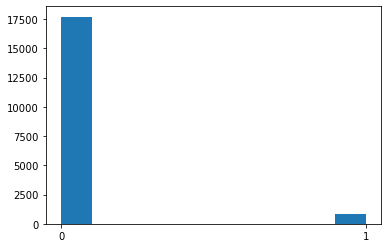

ACADEMIC_STAT_CODE
0                     17708
1                       837
dtype: int64
4.51 %
None


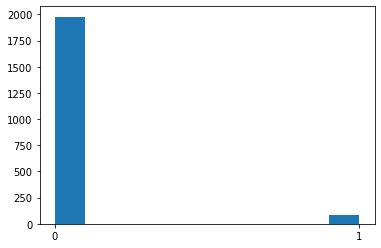

ACADEMIC_STAT_CODE
0                     1978
1                       83
dtype: int64
4.03 %
None


In [4]:
y_train_feature = y_train_feature.replace('탈락',1)
y_train_feature = y_train_feature.replace('유지',0)

y_test_2nd = y_test_2nd.replace('탈락',1)
y_test_2nd = y_test_2nd.replace('유지',0)

plt.hist(y_train_feature)
plt.xticks([0,1])
plt.show()

print(y_train_feature.value_counts())
print(p_100(y_train_feature.value_counts()[1],y_train_feature.value_counts()[0]))

plt.hist(y_test_2nd)
plt.xticks([0,1])
plt.show()

print(y_test_2nd.value_counts())
print(p_100(y_test_2nd.value_counts()[1],y_test_2nd.value_counts()[0]))

## SMOTE
 - 가장 성능을 좋게 하는 ADASYN을 사용

In [5]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# x_train_over,y_train_over = smote.fit_resample(x_train_feature,y_train_feature)

# print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train_feature.shape, y_train_feature.shape)
# print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)

# print('SMOTE 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

In [6]:
# from imblearn.over_sampling import BorderlineSMOTE

# bsmote = BorderlineSMOTE(random_state=42)
# x_train_over,y_train_over = bsmote.fit_resample(x_train_feature,y_train_feature)

# print('BorderlineSMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train_feature.shape, y_train_feature.shape)
# print('BorderlineSMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
# print('BorderlineSMOTE 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

In [7]:
from imblearn.over_sampling import ADASYN

ads = ADASYN(random_state=42)
x_train_over,y_train_over = ads.fit_resample(x_train_feature,y_train_feature)

print('ADASYN 적용 전 학습용 피처/레이블 데이터 세트: ', x_train_feature.shape, y_train_feature.shape)
print('ADASYN 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('ADASYN 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

ADASYN 적용 전 학습용 피처/레이블 데이터 세트:  (18545, 25) (18545, 1)
ADASYN 적용 후 학습용 피처/레이블 데이터 세트:  (35686, 25) (35686, 1)
ADASYN 적용 후 레이블 값 분포: 
 ACADEMIC_STAT_CODE
1                     17978
0                     17708
dtype: int64


## 모델 생성
 - Ensemble : 여러 모델이 동일한 문제를 해결하고 더 나은 결과를 얻도록 훈련시키는 기계 학습 패러다임
   - Voting : 여러 모델을 같은 데이터에 대해 학습하고 모델을 조합해서 단일 모델보다 더 나은 결과를 얻도록 하는 방식
   - Bagging : 단일 모델에서 샘플을 여러번 뽑아(Bootstrap), 여러개의 분류기를 만들어 보팅으로 최종 결정을 하는 방식 (병령)
   - Boosting : 여러 모델이 순차적으로 학습하며 오분류된 객체에 가중치를 조절해서 예측하는 방식 (순차)
   - Stacking : 여러 모델을 결합해 예측결과를 도출하지만, 개별 모델로 예측한 데이터를 기반으로 다시 예측을 진행하는 방식

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import time

#### 튜닝 전 모델 생성
 - 11개의 모델 중 종류별로 성능이 가장 좋은 모델들 중 3개만 선택해서 voting
 - Tree & Bagging : [ DecisionTreeClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier ]
 - Boosting : [ AdaBoostClassifier, GradientBoostingClassifier, XGBClassifier2014, LGBMClassifier ]
 - linear classifier : [ LogisticRegression, SVC ]
 - Nearest Neighbor : [ KNeighborsClassifier ]

In [9]:
start = time.time() 

dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)
xtree_clf = ExtraTreesClassifier(random_state=42)
bag_clf = BaggingClassifier(random_state=42)
gdb_clf = GradientBoostingClassifier(random_state=42)
log_clf = LogisticRegression(random_state=42)
#ridge_clf = RidgeClassifier(random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
lgb_clf = LGBMClassifier(random_state=42)

Tree_Bagging = [dt_clf, rf_clf, bag_clf, xtree_clf]
Boosting = [ada_clf, gdb_clf, xgb_clf, lgb_clf]
linear = [log_clf, svm_clf]
Neighbor = [knn_clf]

mldel_list = [Tree_Bagging, Boosting, linear, Neighbor]
top_list = []
for ml in mldel_list:
    clf_list = ml.copy()
    temp_list = []

    for clf in clf_list:
        clf.fit(x_train_over, y_train_over)
        y_pred = clf.predict(x_test_2nd)
        cf = confusion_matrix(y_test_2nd, y_pred, labels=[1, 0])
        print(clf.__class__.__name__)
        print("confusion_matrix : ")
        print(cf)
        print("accuracy_score : {:.2f}".format(accuracy_score(y_test_2nd,y_pred)*100))
        print("recall_score : {:.2f}".format(recall_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print("precision_score : {:.2f}".format(precision_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print("f1_score : {:.2f}".format(f1_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print()
        temp_list.append([clf, recall_score(y_test_2nd,y_pred,labels=[1, 0])*100])
        temp_list.sort(key=lambda x: (-x[1]))
        
    top_list.append(temp_list[0])

top_list.sort(key=lambda x: (-x[1]))
top_list.pop()

top_estimators = [('top1', top_list[0][0]),
               ('top2', top_list[1][0]),
               ('top3', top_list[2][0])]

voting_clf = VotingClassifier(estimators=top_estimators, voting='soft')

voting_clf.fit(x_train_over, y_train_over)
y_pred = voting_clf.predict(x_test_2nd)
cf = confusion_matrix(y_test_2nd, y_pred, labels=[1, 0])
print(voting_clf.__class__.__name__," : ", end='')
for element in top_estimators:
    print(element[1], ", ", end='')
    if element[1] == top_list[2][0]:
        print()

print("confusion_matrix : ")
print(cf)
print("recall_score : {:.2f}".format(recall_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print("precision_score : {:.2f}".format(precision_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print("f1_score : {:.2f}".format(f1_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print()  
    
end = time.time()     
print(f"{end - start:.5f} sec")

DecisionTreeClassifier
confusion_matrix : 
[[  11   72]
 [ 104 1874]]
accuracy_score : 91.46
recall_score : 13.25
precision_score : 9.57
f1_score : 11.11

RandomForestClassifier
confusion_matrix : 
[[   7   76]
 [  21 1957]]
accuracy_score : 95.29
recall_score : 8.43
precision_score : 25.00
f1_score : 12.61

BaggingClassifier
confusion_matrix : 
[[   5   78]
 [  39 1939]]
accuracy_score : 94.32
recall_score : 6.02
precision_score : 11.36
f1_score : 7.87

ExtraTreesClassifier
confusion_matrix : 
[[   7   76]
 [  35 1943]]
accuracy_score : 94.61
recall_score : 8.43
precision_score : 16.67
f1_score : 11.20

AdaBoostClassifier
confusion_matrix : 
[[  16   67]
 [ 142 1836]]
accuracy_score : 89.86
recall_score : 19.28
precision_score : 10.13
f1_score : 13.28

GradientBoostingClassifier
confusion_matrix : 
[[   2   81]
 [   2 1976]]
accuracy_score : 95.97
recall_score : 2.41
precision_score : 50.00
f1_score : 4.60

XGBClassifier
confusion_matrix : 
[[   4   79]
 [   7 1971]]
accuracy_score : 

#### 모델 튜닝
 - 튜닝을 통해 가장 성능이 좋은 모델 3개를 voting

In [12]:
start = time.time() 

dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)
xtree_clf = ExtraTreesClassifier(random_state=42)
bag_clf = BaggingClassifier(random_state=42)
gdb_clf = GradientBoostingClassifier(random_state=42)
log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
lgb_clf = LGBMClassifier(random_state=42)
knn_clf = KNeighborsClassifier()

Tree_Bagging = [dt_clf, rf_clf, bag_clf, xtree_clf]
Boosting = [ada_clf, gdb_clf, xgb_clf, lgb_clf]
linear = [log_clf, svm_clf]
Neighbor = [knn_clf]

grid_n_estimator = [10, 50, 100, 150, 200]
grid_max_depth = [None, 5, 15, 25]
grid_min_samples = [2, 5, 8]
grid_c = [0.1, 1, 10, 100]
grid_learn = [0.1, 1, 10]
grid_bool = [True, False]
grid_seed = [42]

Tree_Bagging_grid_param = [
                         [{
                        #DecisionTreeClassifier
                        'min_samples_split': grid_min_samples, #default=2
                        'max_depth': grid_max_depth, #default=None
                        'random_state': grid_seed
                         }],
                         [{
                        #RandomForestClassifier
                        'min_samples_split': grid_min_samples, #default=2
                        'max_depth': grid_max_depth, #default=None
                        'random_state': grid_seed
                         }],
                        [{
                        #BaggingClassifier 
                        'n_estimators': grid_n_estimator, #default=10
                        'max_samples': [1, 5, 10], #default=1.0
                        'random_state': grid_seed
                         }],
                        [{
                        #ExtraTreesClassifier 
                        'n_estimators': grid_n_estimator, #default=100
                        'min_samples_split': grid_min_samples, #default=2    
                        'max_depth': grid_max_depth, #default=None
                        'random_state': grid_seed
                         }],
                        ]
Boosting_grid_param = [
                    [{
                    #AdaBoostClassifier
                    'n_estimators': grid_n_estimator, #default=50
                    'learning_rate': grid_learn, #default=1
                    'random_state': grid_seed
                    }],
                    [{
                    #GradientBoostingClassifier 
                    'n_estimators': grid_n_estimator, #default=100
                    #'min_samples_split': grid_min_samples, #default=2  
                    'max_depth': grid_max_depth, #default=3 
                    #'learning_rate': grid_learn, #default=0.1    
                    'random_state': grid_seed
                     }],
                    [{
                    #XGBClassifier
                    'n_estimators': grid_n_estimator, 
                    'max_depth': grid_max_depth,
                    'seed': grid_seed  
                     }],
                    [{
                    #LGBMClassifier -
                    'n_estimators': grid_n_estimator, 
                    'max_depth': grid_max_depth,
                    'seed': grid_seed   
                    }]
                    ]
linear_grid_param = [
                    [{
                    #LogisticRegressionCV 
                    'C': grid_c, #default=1
                    'fit_intercept': grid_bool, #default: True
                    'penalty': ['l1','l2'],
                    'random_state': grid_seed
                     }],
                    [{
                    #SVC 
                    'C': grid_c, #default=1.0
                    'random_state': grid_seed
                     }]
                    ]
Neighbor_grid_param = [
                    [{
                    #KNeighborsClassifier 
                    'n_neighbors': [2,5,6,10], #default: 5
                    'p':[1,2]
                    }],
                    ]



mldel_list = [Tree_Bagging, Boosting, linear, Neighbor]
param_list = [Tree_Bagging_grid_param, Boosting_grid_param, linear_grid_param, Neighbor_grid_param]

top_list = []
for ml, grid_param in zip(mldel_list, param_list):
    clf_list = ml.copy()
    print(clf_list)
    temp_list = []

    for clf, param in zip(clf_list,grid_param):
        param_start = time.time() 
        print(clf)
        print(param)
        grid_cv = GridSearchCV(estimator=clf, param_grid=param, scoring='f1', cv=3, verbose=1)
        grid_cv.fit(x_train_over, y_train_over)
        best_param = grid_cv.best_params_     
        clf.set_params(**best_param)
        y_pred = grid_cv.predict(x_test_2nd)

        param_end = time.time()
        run = param_end - param_start

        print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf.__class__.__name__, best_param, run))
        cf = confusion_matrix(y_test_2nd, y_pred, labels=[1, 0])
        print("confusion_matrix : ")
        print(cf)
        print("recall_score : {:.2f}".format(recall_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print("precision_score : {:.2f}".format(precision_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print("f1_score : {:.2f}".format(f1_score(y_test_2nd,y_pred,labels=[1, 0])*100))
        print()
        temp_list.append([clf, recall_score(y_test_2nd,y_pred,labels=[1, 0])*100])
        temp_list.sort(key=lambda x: (-x[1]))
    top_list.append(temp_list[0])
    
top_list.sort(key=lambda x: (-x[1]))
top_list.pop()

top_estimators = [('top1', top_list[0][0]),
               ('top2', top_list[1][0]),
               ('top3', top_list[2][0])]


voting_clf = VotingClassifier(estimators=top_estimators, voting='soft')

best_clf = voting_clf.fit(x_train_over, y_train_over)
y_pred = best_clf.predict(x_test_2nd)
cf = confusion_matrix(y_test_2nd, y_pred, labels=[1, 0])
print(voting_clf.__class__.__name__," : ", end='')
for element in top_estimators:
    print(element[1], ", ", end='')
    if element[1] == top_list[2][0]:
        print()

print("confusion_matrix : ")
print(cf)
print("recall_score : {:.2f}".format(recall_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print("precision_score : {:.2f}".format(precision_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print("f1_score : {:.2f}".format(f1_score(y_test_2nd,y_pred,labels=[1, 0])*100))
print()  
    
end = time.time()     
print(f"{end - start:.5f} sec")

[DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), BaggingClassifier(random_state=42), ExtraTreesClassifier(random_state=42)]
DecisionTreeClassifier(random_state=42)
[{'min_samples_split': [2, 5, 8], 'max_depth': [None, 5, 15, 25], 'random_state': [42]}]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
ERROR! Session/line number was not unique in database. History logging moved to new session 693
The best parameter for DecisionTreeClassifier is {'max_depth': 25, 'min_samples_split': 8, 'random_state': 42} with a runtime of 3.65 seconds.
confusion_matrix : 
[[   8   75]
 [  58 1920]]
recall_score : 9.64
precision_score : 12.12
f1_score : 10.74

RandomForestClassifier(random_state=42)
[{'min_samples_split': [2, 5, 8], 'max_depth': [None, 5, 15, 25], 'random_state': [42]}]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameter for RandomForestClassifier is {'max_depth': None, 'min_samples_split': 5, 'random_state': 42} w

## 모델 저장

In [14]:
import pickle
with open('./model/student_model_final.pickle','wb') as fw:
    pickle.dump(best_clf, fw)